## Importing Required Libraries

In [3]:
!pip install sentence_transformers -q
import pandas as pd
from nltk.corpus import stopwords
from nltk import download
download('stopwords')
import re
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import numpy as np

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Importing Data

In [4]:
# Labelled data
labelled=pd.read_csv('/content/drive/MyDrive/Dataset/UNGDC/labelled_data.csv')
labelled.drop('Unnamed: 0', axis=1, inplace=True)

# Unlabelled data
unlabelled=pd.read_csv('/content/drive/MyDrive/Dataset/UNGDC/unlabelled_data.csv')

# Removing labelled sentences from unlabelled dataset
mask = unlabelled['country'].isin(labelled['country']) & unlabelled['year'].isin(labelled['year']) & unlabelled['doc_id'].isin(labelled['doc_id'])
unlabelled = unlabelled[~mask]
unlabelled.drop('Unnamed: 0', axis=1, inplace=True)

### Frequency Count of Labels

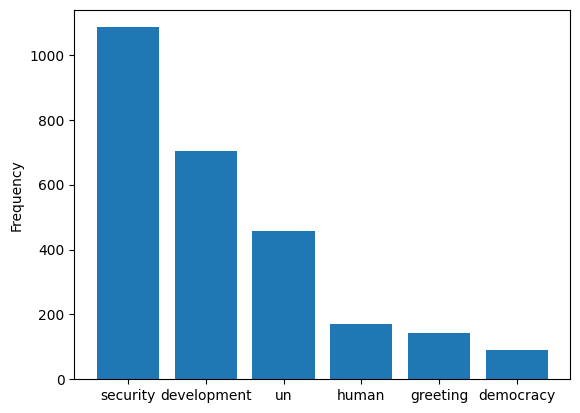

In [5]:
freq = labelled['coding'].value_counts()
plt.bar(freq.index, freq.values)
plt.ylabel('Frequency')
plt.show()

## Preprocessing

1. Remove stopwords (the, a , an...).
2. Remove punctuation (:, , ., ?...).
3. Remove Numbers (1, 199, 12)
4. Remove whitespaces.
5. Converting words into lowercase
6. Tokenization (sentence -> list of words)

In [6]:
class Preprocessor:
  '''
    Removes punctuations, numbers, whitespaces
    Converts sentences into lower case
  '''

  def __init__(self, numbers=True, punct=True, stopwords=True, empty_sentence=True, model='bert-base-nli-mean-tokens'):
    self.numbers = numbers
    self.punct = punct
    self.stopwords = stopwords
    self.empty_sentence = empty_sentence
    self.model = SentenceTransformer(model)

  def apply(self, sentence):
    sentence = sentence.lower()
    if self.numbers:
      sentence = Preprocessor.remove_numbers(sentence)

    if self.punct: 
      sentence = Preprocessor.remove_punct(sentence)

    if self.stopwords: 
      sentence = Preprocessor.remove_stopwords(sentence)

    if self.empty_sentence: 
      sentence = Preprocessor.empty_sentence(sentence)

    if sentence!=None:
        sentence = re.sub(r'\s+', ' ', sentence)

    return sentence
  
  @staticmethod
  def remove_punct(sentence):
    sentence = re.sub(r'[^\w\s]', '', sentence)
    return sentence
  
  @staticmethod
  def remove_numbers(sentence):
    sentence = re.sub(r'[0-9]', '', sentence)
    return sentence

  @staticmethod
  def remove_stopwords(sentence):
    sentence_clean = ' '.join( [ word for word in sentence.split() if word.lower() not in set( stopwords.words('english') ) ] )
    return sentence_clean

  
  @staticmethod
  def empty_sentence(sentence):
    words=sentence.split()
    if (not all(elem == "" for elem in sentence)) and len(sentence)>2:
        return sentence
    else:
        return None

  def get_embedding(self, sentence):
      return self.model.encode(sentence)
processor = Preprocessor()

In [7]:
# Labelled Data
labelled_cleaned=labelled.copy()
labelled_cleaned['text_clean']=labelled_cleaned['text'].apply(processor.apply)
labelled_cleaned.dropna(inplace=True)
labelled_cleaned.reset_index(inplace=True, drop=True)
labelled_cleaned['embeddings']=labelled_cleaned['text_clean'].apply(processor.get_embedding)

In [8]:
# Unlabelled Data
unlabelled_cleaned=unlabelled.sample(2000)
unlabelled_cleaned['text_clean']=unlabelled_cleaned['text'].apply(processor.apply)
unlabelled_cleaned.dropna(inplace=True)
unlabelled_cleaned.reset_index(inplace=True, drop=True)
unlabelled_cleaned['embeddings']=unlabelled_cleaned['text_clean'].apply(processor.get_embedding)

In [9]:
labelled_cleaned.to_csv('labelled_cleaned.csv')
np.save('labelled_embeddings.npy', np.stack(labelled_cleaned['embeddings'].tolist()))

unlabelled_cleaned.to_csv('unlabelled_cleaned.csv')
np.save('unlabelled_embeddings_2k.npy', np.stack(unlabelled_cleaned['embeddings'].tolist()))